[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/2022-23_final/final.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/Danysan1/ai-unibo-nlp-project/blob/main/2022-23_final/final.ipynb)
[![Open in SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/Danysan1/ai-unibo-nlp-project/tree/main/2022-23_final/final.ipynb)

# Final project

## Imports and Initial Settings

In [1]:
%pip install pandas numpy matplotlib transformers==4.25.1  dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.10
    Uninstalling SQLAlchemy-2.0.10:
      Successfully uninstalled SQLAlchemy-2.0.10


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from os import path
from matplotlib import pyplot as plt
import random
import gc
import torch
import transformers
from tqdm import tqdm
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [3]:
# Fix the random state to 42
SEED = 42

# Define the labels for the target
labels = ['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']

# if a different set of labels is needed, decomment the next lines and select a different subset of labels,
# but always use the variable 'labels' since all the code will use that. If you want to select
# the full set of labels, just comment the next two lines

#suggested_labels = ['Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']
#labels = suggested_labels

In [4]:
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

## Dataset Download

In [5]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.tsv')
    if not os.path.exists(data_path):
        print(f"Downloading Touché23-ValueEval {suffix} data... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [6]:
data_folder = 'Dataset'

In [7]:
# Training data
training = {'suffix': 'arguments-training', 'url': "https://zenodo.org/record/7550385/files/arguments-training.tsv?download=1"}
labels_training = {'suffix': 'labels-training', 'url': "https://zenodo.org/record/7550385/files/labels-training.tsv?download=1"}
level1_labels_training = {'suffix': 'level1-labels-training', 'url': "https://zenodo.org/record/7550385/files/level1-labels-training.tsv?download=1"}

# Validation data
validation = {'suffix': 'arguments-validation', 'url': "https://zenodo.org/record/7550385/files/arguments-validation.tsv?download=1"}
labels_validation = {'suffix': 'labels-validation', 'url': "https://zenodo.org/record/7550385/files/labels-validation.tsv?download=1"}
level1_labels_validation = {'suffix': 'level1-labels-validation', 'url': "https://zenodo.org/record/7550385/files/level1-labels-validation.tsv?download=1"}

# Test data
test = {'suffix': 'arguments-test', 'url': "https://zenodo.org/record/7550385/files/arguments-test.tsv?download=1"}

to_download = [training, 
                labels_training,
                validation,
                labels_validation]

In [8]:
for data in to_download:
    download_data(data_path=data_folder, url_path=data['url'], suffix=data['suffix'])

arguments-training.tsv?download=1: 1.02MB [00:03, 270kB/s]                           


Download completed!


labels-training.tsv?download=1: 254kB [00:02, 115kB/s]                           


Download completed!


arguments-validation.tsv?download=1: 369kB [00:02, 158kB/s]                           


Download completed!


labels-validation.tsv?download=1: 90.1kB [00:01, 72.5kB/s]                            

Download completed!


## Dataset Loading

In [9]:
def load_touche_dataset(filename:str) -> pd.DataFrame:
    with open(path.join(data_folder, filename)) as file_obj:
        data = pd.read_csv(path.join(data_folder, filename), sep='\t', header=0, index_col='Argument ID')
        return data

In [10]:
def filter_labels(labels_df:pd.DataFrame, subset:pd.Series) -> pd.DataFrame:
    """
        Given a DataFrame of labels (e.g. from labels-training.tsv), this method drops all the columns not contained in the subset list 
    """
    m = labels_df[subset].mask(labels_df[subset] == 0).dropna(how='all').replace(np.NaN, 0)
    return pd.DataFrame(m, dtype=int)

def filter_indexes(data_df:pd.DataFrame, subset:pd.Series) -> pd.DataFrame:
    """
        Given a DataFrame of arguments (e.g. from arguments-training.tsv), this method drops all the rows with indexes not contained in the subset list.
        This method is useful after a labels DataFrame has been filtered, because it removes rows that couldn't be classificated
    """
    return data_df.filter(subset, axis='index')

In [11]:
train_labels_df = filter_labels(load_touche_dataset("labels-training.tsv"), subset=labels)
train_df = filter_indexes(load_touche_dataset("arguments-training.tsv"), subset=train_labels_df.index) 
val_labels_df = filter_labels(load_touche_dataset("labels-validation.tsv"), subset=labels)
val_df = filter_indexes(load_touche_dataset("arguments-validation.tsv"), subset=val_labels_df.index)
train_df.head() 

,Conclusion,Stance,Premise
Argument ID,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [12]:
val_df.head()

,Conclusion,Stance,Premise
Argument ID,,,
A01001,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...
A01012,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...
A02001,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...
A02002,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...
A02009,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...


In [13]:
train_labels_df.head()

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,
A01002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
A01006,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
A01008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [14]:
from sklearn.model_selection import train_test_split
# TODO train_test_split

In [15]:
train_df.describe().drop(index=['top'], axis=1)

,Conclusion,Stance,Premise
count,5392,5392,5392
unique,332,2,5312
freq,114,2898,2


A barplot to describe the representation in the dataset of each argument's category

<BarContainer object of 20 artists>

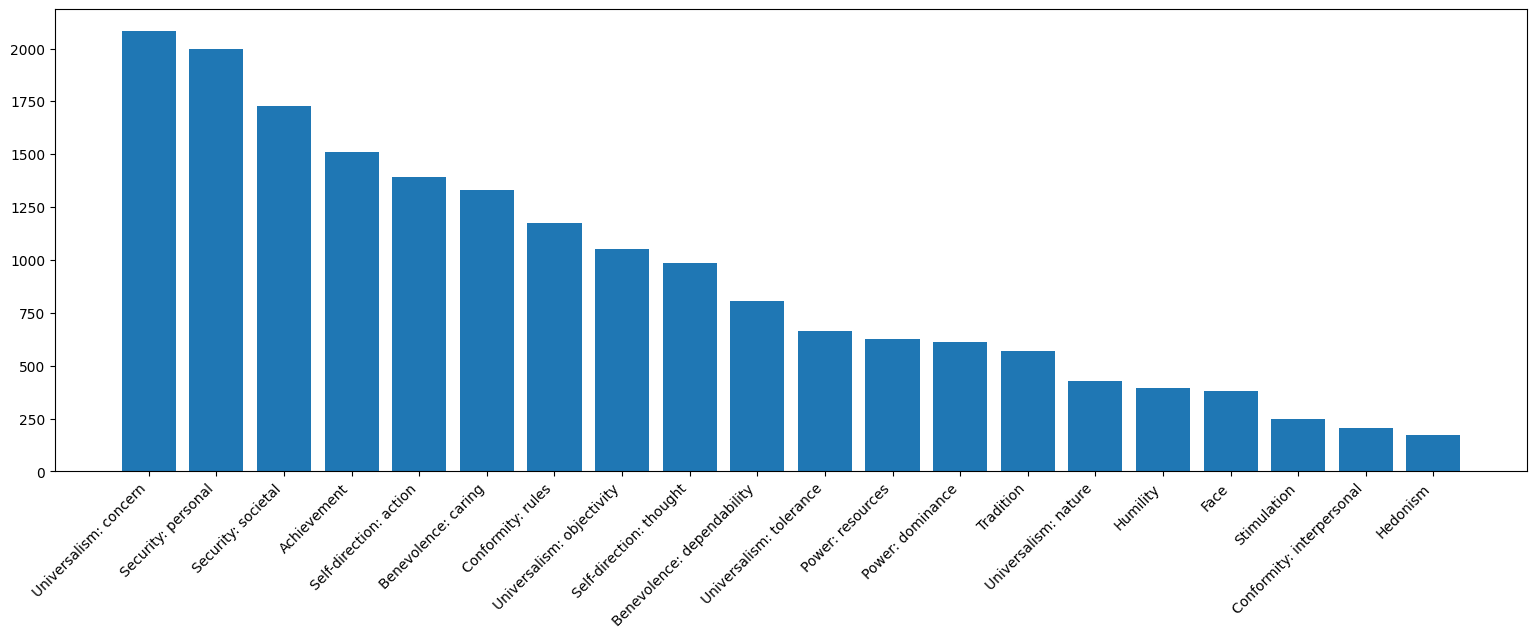

In [16]:
values = train_labels_df.sum().sort_values(ascending=False)
y = np.array(values)
x = np.array(values.index)

plt.figure(figsize=(19,6))
plt.xticks(rotation=45, ha="right")
plt.bar(x, height=y)

In [17]:
labels_names = train_labels_df.columns.tolist()
labels_names

['Self-direction: thought',
 'Self-direction: action',
 'Stimulation',
 'Hedonism',
 'Achievement',
 'Power: dominance',
 'Power: resources',
 'Face',
 'Security: personal',
 'Security: societal',
 'Tradition',
 'Conformity: rules',
 'Conformity: interpersonal',
 'Humility',
 'Benevolence: caring',
 'Benevolence: dependability',
 'Universalism: concern',
 'Universalism: nature',
 'Universalism: tolerance',
 'Universalism: objectivity']

In [18]:
train_labels_df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

## Baseline model

In [19]:
from sklearn.metrics import accuracy_score, classification_report
dummy_predictions = np.ones(val_labels_df.shape)
print(classification_report(val_labels_df.values, dummy_predictions, target_names = labels_names, zero_division = 0))

                            precision    recall  f1-score   support

   Self-direction: thought       0.13      1.00      0.23       251
    Self-direction: action       0.26      1.00      0.41       496
               Stimulation       0.07      1.00      0.14       138
                  Hedonism       0.05      1.00      0.10       103
               Achievement       0.30      1.00      0.47       575
          Power: dominance       0.09      1.00      0.16       164
          Power: resources       0.07      1.00      0.13       132
                      Face       0.07      1.00      0.13       130
        Security: personal       0.40      1.00      0.57       759
        Security: societal       0.26      1.00      0.41       488
                 Tradition       0.09      1.00      0.17       172
         Conformity: rules       0.24      1.00      0.39       455
 Conformity: interpersonal       0.03      1.00      0.06        60
                  Humility       0.07      1.00

## Pytorch Dataset

In [20]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Model

In [21]:
def getModel(model_checkpoint, num_labels):

  model = CustomBERTModel(model_checkpoint, num_labels)
  #binary cross entropy
  #criterion = nn.BCELoss()
  #optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
  
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

  return model, tokenizer

In [22]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim, 
          criterion: torch.nn.Module,
          epoch: int) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
    """    
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids,
                              attention_mask=attention_mask,
                        )
        loss = criterion(logits, labels)
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step() 
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module, 
             criterion: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids,
                                  attention_mask=attention_mask,
                            )
            loss = criterion(logits, labels)
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [23]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim, 
                  criterion: torch.nn.Module,
                  model: torch.nn.Module, 
                  loader_train: torch.utils.data.DataLoader, 
                  loader_val : torch.utils.data.DataLoader = None, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, loader_train, device, 
                                           optimizer, criterion, epoch)
        if(loader_val != None):
          loss_val = validate(model, criterion, loader_val, device)
        else:
          loss_val = 0
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

In [24]:
def execute(lr: float, 
            num_epochs: int, 
            batch_size: int,
            criterion: torch.nn.Module,
            num_labels: int,
            data: pd.DataFrame,
            data_labels: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels: pd.DataFrame,
            cross_val: bool=False,
            model_name="",
            model=None,
            tokenizer=None
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the 
        tokenizer, and then executes the training loop.

    Args:
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        data: training-val dataframe.
        data_labels: training-val labels dataframe.
        val_df: validation dataframe.
        model: the network to train.
        history: questions-answers history flag.
    """
    #get the model and the tokenizer
    if not model_name == "":
        model, tokenizer = getModel(model_name, num_labels)
    if(cross_val):
      #cross validation, consider the validation size as about 20% of the training data
      k = 5
      fold_size = len(data) // k
      validation_scores = []
      #shuffle the data before start training
      idx = list(range(0,len(data)))
      np.random.shuffle(idx)
      shuffled_data = data.iloc[idx,:]
      shuffled_labels = data_labels.iloc[idx,:]
      print(f'STARTING TRAINING with {k}-CROSS-VAL:')
      for i in range(0,k):
        val_data = shuffled_data[i*fold_size:(i+1)*fold_size]
        val_data_labels = shuffled_labels[i*fold_size:(i+1)*fold_size]
        train_data = pd.concat([shuffled_data[:i*fold_size],shuffled_data[(i+1)*fold_size :]], ignore_index=True)
        train_data_labels = pd.concat([shuffled_labels[:i*fold_size],shuffled_labels[(i+1)*fold_size :]], ignore_index=True)
        #get the model and the tokenizer
        if not model_name == "":
          model, tokenizer = getModel(model_name, num_labels)
        #Start encodings
        #print(f'STARTING ENCODING:')
        #print(f'Train set:')
        train_encodings = encode(tokenizer, train_data, train_data_labels)
        #print(f'Validation set:')
        val_encodings = encode(tokenizer, val_data, val_data_labels)
        #print(f'ENCODING COMPLETE.')

        #create training dataset
        train_dataset = CreateDataset(train_encodings)
        #create training dataloader
        data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle = True
                                            )
        #create validation dataset
        val_dataset = CreateDataset(val_encodings)
        #create validation dataloader
        data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle = False
                                            )

        #Optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
       
        statistics = training_loop(num_epochs, optimizer, criterion, model,
                                  data_loader_train, data_loader_val)
        validation_score = np.mean(statistics['val_loss_values'])
        validation_scores.append(validation_score)
      #final val score
      val_score = np.average(validation_scores)
      print(f"Validation_score: {val_score}")
      print(f'Cross validation complete.')
    #train on full data
    #get the model and the tokenizer
    if not model_name == "":
      model, tokenizer = getModel(model_name, num_labels)
    #Start encodings
    #print(f'Train set:')
    train_encodings = encode(tokenizer, data, data_labels)
    if(not cross_val):
      #print(f'Validation set:')
      val_encodings = encode(tokenizer, val_df, val_labels)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CreateDataset(train_encodings)
    #create training dataloader
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = True
                                        )
    #create validation dataset
    if(cross_val):
      data_loader_val = None

    else:
      val_dataset = CreateDataset(val_encodings)
      #create validation dataloader
      data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle = False
                                          )
    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    print(f'STARTING TRAINING with complete data:')
    statistics = training_loop(num_epochs, optimizer, criterion, model,
                              data_loader_train, data_loader_val)
    print(f'TRAINING COMPLETE.')

    return model, tokenizer, statistics

In [25]:
def evaluate(model, criterion, data_loader, device):
  average_loss = []
  predictions = []
  model.eval()
  model.to(device)
  first = True
  loop = tqdm(data_loader_val)
  with torch.no_grad():
    for batch in loop:
      target = batch['labels'].to(device)
      prediction = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))
      predictions.append(prediction)
      loss = criterion(prediction,target)
      average_loss.append(loss.item())
    
  loss = np.mean(average_loss)
  print(f"\naverage loss on val set: {loss}")

  return predictions

In [26]:
def encode(tokenizer, df, labels):
    #premise , stance, conclusion  --> premise, stance + conclusion
    #append the stance to the conclusion by putting a separator between them
  sequence_sc = df["Stance"].str.cat(df["Conclusion"], sep = '[SEP]') # If needed a separator can be passed, for example with sep='[SEP] '
  encodings = tokenizer(list(df['Premise']), list(sequence_sc), 
                          padding=True,
                          truncation=True,
                          max_length = 250
                          )
  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
  encodings.update({'labels' : torch.FloatTensor(labels.values)})
  encodings.pop('token_type_ids')
  return encodings

An example of encoded row is:
'[CLS]', 'we', 'should', 'ban', 'human', 'cl', '##oning', 'as',
       'it', 'will', 'only', 'cause', 'huge', 'issues', 'when', 'you',
       'have', 'a', 'bunch', 'of', 'the', 'same', 'humans', 'running',
       'around', 'all', 'acting', 'the', 'same', '.', '[SEP]', 'in',
       'favor', 'of', '[SEP]', 'we', 'should', 'ban', 'human', 'cl',
       '##oning', '[SEP]', '[PAD]'

In [27]:
from sklearn.metrics import f1_score 
def find_threshold(y_p, y_true,labels):
  '''
    Finds the optimal threshold for the F1-score for each label. 
    -------------
    Returns a list
  '''
  result = {}
  max_thresh = 0.6
  min_thresh = 0.05
  step = 0.05
  thresh_v = np.arange(min_thresh, max_thresh, step)
  for lbl in range(len(labels)):
    _pred = [item[lbl] for item in y_p]
    _true = [item[lbl] for item in y_true]
    scores = []
    for threshold in thresh_v:
      _y_pred=[]
      _y_pred.append([1 if sample>=threshold else 0 for sample in _pred])
      _y_pred = np.array(_y_pred).reshape(-1)
      scores.append(np.round(f1_score(_true, _y_pred, average="macro"),2))
    result[labels[lbl]] = scores
  print(result)
  
  best_thresholds = []
  for lbl in result:
    best_thresholds.append(thresh_v[np.argmax(result[lbl])])
  return best_thresholds

In [28]:
#premise = train_df['Premise']
#stance = train_df['Stance']
#conclusion = train_df['Conclusion'] 
num_labels = train_labels_df.shape[1]

In [29]:
#model_checkpoint= 'prajjwal1/bert-tiny'
#model_checkpoint = "distilbert-base-uncased"
model_checkpoint = 'bert-base-uncased'
#tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

#eos_token  = tokenizer.cls_token_id
#sep_token  = tokenizer.sep_token_id

In [30]:
'''
encodings = tokenizer(list(train_df['Premise']), list(sequence_sc), 
                          padding=True,
                          truncation=True,
                          max_length = 250
                          )
input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
#label_values = tokenizer(answers,padding=True,truncation=True,max_length = 60)
#labels, labels_mask = label_values['input_ids'], label_values['attention_mask']


#max_length = len(labels[0])

#masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]
print(f'length of input_ids: {np.shape(input_ids)}')

#add targets to the encodings dictionary
encodings.update({'labels' : torch.FloatTensor(train_labels_df.values)})
'''

"\nencodings = tokenizer(list(train_df['Premise']), list(sequence_sc), \n                          padding=True,\n                          truncation=True,\n                          max_length = 250\n                          )\ninput_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']\n#label_values = tokenizer(answers,padding=True,truncation=True,max_length = 60)\n#labels, labels_mask = label_values['input_ids'], label_values['attention_mask']\n\n\n#max_length = len(labels[0])\n\n#masked_labels = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in labels]\nprint(f'length of input_ids: {np.shape(input_ids)}')\n\n#add targets to the encodings dictionary\nencodings.update({'labels' : torch.FloatTensor(train_labels_df.values)})\n"

In [31]:
#len(encodings.items())

In [32]:
#encodings['labels'][:3]

In [33]:
#np.array(tokenizer.batch_decode(input_ids[0])).squeeze()

In [166]:
#parameters
lr = 7e-5
batch_size = 32
epochs = 1
cross_val = False
criterion = torch.nn.BCELoss()

In [ ]:
ncol = train_labels_df.columns.size
cols = train_labels_df.columns

cprobabilities = torch.eye(ncol, dtype=torch.float32)
cprobabilities

for i in range(ncol):
  for j in range(ncol):
    if i != j:
      cprobabilities[j,i] = train_labels_df[train_labels_df[cols[i]]==1].sum()[cols[j]]/(train_labels_df.sum()[cols[i]]+1)

cprobabilities

In [167]:
from transformers import DistilBertModel, BertModel
import torch.nn as nn

class GCNConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNConv, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = torch.sparse.mm(x, cprobabilities)
        return x

class CustomBERTModel(nn.Module):
    
    def __init__(self,checkpoint,num_labels):
          super(CustomBERTModel, self).__init__()
          self.num_labels = num_labels
          #self.model = model = DistilBertModel.from_pretrained(checkpoint)
          self.model = model = BertModel.from_pretrained(checkpoint)
          ### New layers:
          self.conv1 = GCNConv(self.model.config.hidden_size, 256)
          self.sigmoid = torch.sigmoid(x)
          self.l1 = nn.Dropout(0.15)
          self.l2 = nn.Linear(self.model.config.hidden_size, 400)
          self.classifier = nn.Linear(400, num_labels) ## num_labels are the number of classes 
          #self.classifier = nn.Linear(self.model.config.hidden_size, num_labels) ## num_labels are the number of classes 

    def forward(self, input_ids, attention_mask):
          output = self.model(
               input_ids, 
               attention_mask=attention_mask)
          sequence_output = output[0]
          #the pooler output contains the information 
          pooler_output = output.pooler_output
          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          #x = self.linear1(sequence_output[:,0,:].view(-1,768)) ## extract the 1st token's embeddings CLS
         # x = self.l1(pooler_output)
          x = self.conv1(pooler_output, cprobabilities)
          x = self.sigmoid(x)
          x = self.l1(x)
          x = self.l2(x)
          #x = self.l3(x)
          #x = self.l4(x)
          x = self.classifier(x)
          #x = self.classifier(pooler_output)
          output = torch.sigmoid(x)
          return output

The Bert model is trained only for 3 epochs as suggested by its authors.

In [168]:
#execute
model, tokenizer, statistics = execute(lr, epochs, batch_size, criterion, num_labels, train_df, train_labels_df, val_df, val_labels_df,cross_val = cross_val, model_name=model_checkpoint)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predic

ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/169 [00:00<?, ?it/s]<ipython-input-20-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 169/169 [02:21<00:00,  1.19it/s, loss=0.338]


Epoch: 1  Lr: 0.00007000  Loss: Train = [0.3985] - Val = [0.3635]  Time one epoch (s): 159.6693 


Epoch 2: 100%|██████████| 169/169 [02:25<00:00,  1.17it/s, loss=0.343]


Epoch: 2  Lr: 0.00007000  Loss: Train = [0.3340] - Val = [0.3464]  Time one epoch (s): 163.3250 


Epoch 3: 100%|██████████| 169/169 [02:25<00:00,  1.16it/s, loss=0.256]


Epoch: 3  Lr: 0.00007000  Loss: Train = [0.2904] - Val = [0.3415]  Time one epoch (s): 163.6212 
Time for 3 epochs (s): 486.616
TRAINING COMPLETE.


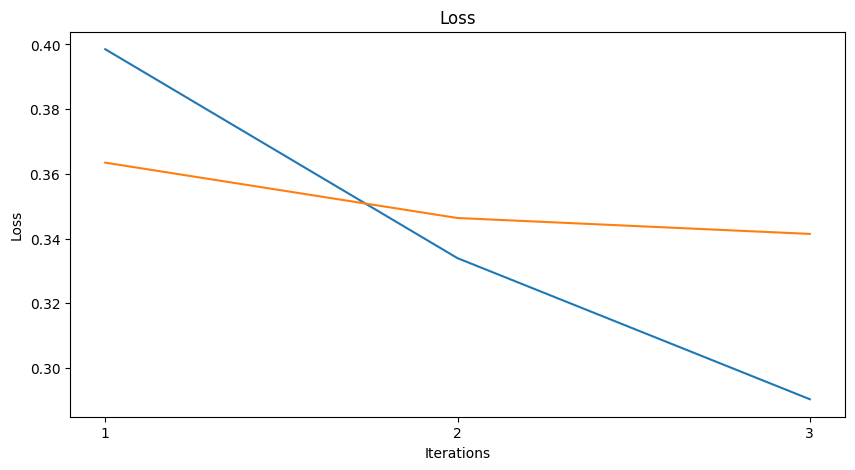

In [169]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(statistics['train_loss_values'],label="train loss")
plt.plot(statistics['val_loss_values'],label="validation loss")
plt.xlabel("Iterations")
plt.xticks(np.arange(epochs), np.arange(1, epochs+1, 1))
plt.ylabel("Loss")
plt.show()

In [170]:
test_encodings = encode(tokenizer,val_df, val_labels_df)
val_dataset = CreateDataset(test_encodings)
#create training dataloader
eval_batch_size = 8
data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=eval_batch_size,
                                        shuffle = False
                                        )

In [171]:
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()
gc.collect()

0

In [172]:
!nvidia-smi

Fri May 19 16:18:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    40W /  70W |   8599MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [173]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
#compute predictions
predictions = evaluate(model, criterion, data_loader_val, device)
predictions = torch.stack(predictions).detach().cpu()
np.shape(predictions)

  0%|          | 0/237 [00:00<?, ?it/s]<ipython-input-20-4004cf27e00a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 237/237 [00:18<00:00, 12.74it/s]


average loss on val set: 0.340122088852814


torch.Size([237, 8, 20])

In [174]:
#reshape
y_p = []
for idx in range(len(predictions)):
  for b in range(eval_batch_size):
    y_p.append(predictions[idx][b])

y_true = np.array(val_labels_df)

In [175]:
np.shape(torch.stack(y_p).detach().cpu())

torch.Size([1896, 20])

In [211]:
#compute this on validation set during the training phase and not on the test set 
threshold =np.linspace(0.2,0.8,40)
best_threshold = threshold[0]
best_score = 0
for t in threshold:
  y_pred=[]
  for sample in y_p:
    y_pred.append([1 if i>=t else 0 for i in sample])
  y_pred = np.array(y_pred)
  y_pred.shape
  report = classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0, output_dict = True) 
  macro_f1 = report['macro avg']['f1-score']
  if(macro_f1 > best_score):
    #print(macro_f1)
    best_score = macro_f1
    best_threshold = t
  

In [207]:
print(best_threshold)

0.2153846153846154


In [208]:
#tried different static threshold values, but seems in overall the value 0.35 works well
y_pred=[]
for sample in y_p:
  y_pred.append([1 if i>=best_threshold else 0 for i in sample])
y_pred = np.array(y_pred)
y_pred.shape
report = classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0)
print(report) 

                            precision    recall  f1-score   support

   Self-direction: thought       0.39      0.66      0.49       251
    Self-direction: action       0.47      0.62      0.54       496
               Stimulation       0.40      0.19      0.26       138
                  Hedonism       0.49      0.21      0.30       103
               Achievement       0.48      0.87      0.62       575
          Power: dominance       0.22      0.41      0.29       164
          Power: resources       0.31      0.75      0.44       132
                      Face       0.31      0.07      0.11       130
        Security: personal       0.66      0.86      0.75       759
        Security: societal       0.46      0.79      0.58       488
                 Tradition       0.48      0.38      0.43       172
         Conformity: rules       0.37      0.72      0.49       455
 Conformity: interpersonal       0.33      0.02      0.03        60
                  Humility       0.13      0.02

In [189]:
accuracy_score(y_true, y_pred)

0.07436708860759493

In [187]:
"""
threshold = 0.5
y_pred=[]
for sample in predictions:
  y_pred.append([1 if i>=threshold else 0 for i in sample.squeeze(dim=0)])
y_pred = np.array(y_pred)
y_pred.shape
"""

'\nthreshold = 0.5\ny_pred=[]\nfor sample in predictions:\n  y_pred.append([1 if i>=threshold else 0 for i in sample.squeeze(dim=0)])\ny_pred = np.array(y_pred)\ny_pred.shape\n'

## Single function (fixed threshold)

In [57]:
def test_run(lr: float, 
            num_epochs: int, 
            batch_size: int,
            criterion: torch.nn.Module,
            num_labels: int,
            train_df: pd.DataFrame,
            train_labels_df: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels_df: pd.DataFrame,
            test_df: pd.DataFrame,
            test_labels_df: pd.DataFrame,
            model_name="",
            model=None,
            tokenizer=None):
  # Training
  actual_model, actual_tokenizer, statistics = execute(lr, num_epochs, batch_size, criterion, num_labels, train_df, train_labels_df, val_df, val_labels_df, model_name, model, tokenizer)
  # Plot training loss
  plt.figure(figsize=(10,5))
  plt.title("Loss")
  plt.plot(statistics['train_loss_values'],label="train loss")
  plt.plot(statistics['val_loss_values'],label="validation loss")
  plt.xlabel("Iterations")
  plt.xticks(np.arange(num_epochs), np.arange(1, num_epochs+1, 1))
  plt.ylabel("Loss")
  plt.show()
  # Testing
  test_encodings = encode(tokenizer,test_df, test_labels_df)
  test_dataset = CreateDataset(test_encodings)
  eval_batch_size = 8
  data_loader_test = torch.utils.data.DataLoader(test_dataset,batch_size=eval_batch_size,shuffle = False)
  predictions = evaluate(model, criterion, data_loader_test, device)
  predictions = torch.stack(predictions).detach().cpu()
  y_p = []
  for idx in range(len(predictions)):
    for b in range(eval_batch_size):
      y_p.append(predictions[idx][b])
  threshold = 0.35
  y_pred=[]
  for sample in y_p:
    y_pred.append([1 if i>=threshold else 0 for i in sample])
  y_pred = np.array(y_pred)
  y_pred.shape
  y_true = np.array(test_labels_df)
  print(classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0))

In [ ]:
test_run(lr, epochs, batch_size, criterion, num_labels, train_df, train_labels_df, val_df, val_labels_df, val_df, val_labels_df, model_name=model_checkpoint)

### Using best threshold for every label

In [109]:
best_thresholds = find_threshold(y_p, y_true, labels)

{'Self-direction: thought': [0.53, 0.6, 0.63, 0.66, 0.69, 0.69, 0.7, 0.71, 0.72, 0.72, 0.72], 'Self-direction: action': [0.34, 0.52, 0.61, 0.65, 0.67, 0.68, 0.69, 0.69, 0.68, 0.67, 0.67], 'Stimulation': [0.5, 0.59, 0.62, 0.62, 0.63, 0.63, 0.63, 0.62, 0.6, 0.59, 0.57], 'Hedonism': [0.57, 0.63, 0.66, 0.68, 0.68, 0.7, 0.69, 0.67, 0.66, 0.65, 0.64], 'Achievement': [0.37, 0.51, 0.59, 0.63, 0.67, 0.7, 0.71, 0.73, 0.75, 0.75, 0.74], 'Power: dominance': [0.35, 0.51, 0.6, 0.63, 0.63, 0.63, 0.61, 0.59, 0.58, 0.56, 0.55], 'Power: resources': [0.53, 0.65, 0.69, 0.71, 0.71, 0.72, 0.71, 0.69, 0.68, 0.67, 0.65], 'Face': [0.39, 0.51, 0.56, 0.58, 0.57, 0.53, 0.51, 0.5, 0.49, 0.49, 0.48], 'Security: personal': [0.48, 0.62, 0.69, 0.73, 0.75, 0.75, 0.76, 0.77, 0.78, 0.78, 0.78], 'Security: societal': [0.38, 0.55, 0.62, 0.66, 0.69, 0.72, 0.73, 0.74, 0.75, 0.75, 0.75], 'Tradition': [0.6, 0.66, 0.66, 0.67, 0.67, 0.66, 0.65, 0.66, 0.65, 0.63, 0.61], 'Conformity: rules': [0.37, 0.53, 0.61, 0.66, 0.68, 0.69, 0.

In [110]:
y_pred=[]
for sample in y_p:
  res = []
  for value,lbl in zip(sample,range(len(labels))):
    res.append(1 if value>=best_thresholds[lbl] else 0)
  y_pred.append(res)
y_pred = np.array(y_pred)

In [111]:
print(classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0))

                            precision    recall  f1-score   support

   Self-direction: thought       0.50      0.52      0.51       251
    Self-direction: action       0.52      0.59      0.56       496
               Stimulation       0.33      0.29      0.31       138
                  Hedonism       0.43      0.43      0.43       103
               Achievement       0.61      0.71      0.66       575
          Power: dominance       0.29      0.45      0.35       164
          Power: resources       0.42      0.56      0.48       132
                      Face       0.21      0.25      0.23       130
        Security: personal       0.72      0.75      0.74       759
        Security: societal       0.66      0.58      0.62       488
                 Tradition       0.54      0.30      0.39       172
         Conformity: rules       0.51      0.58      0.54       455
 Conformity: interpersonal       0.13      0.38      0.20        60
                  Humility       0.16      0.03

In [ ]:
"""
x = val_df[:1]
target = val_labels_df[:1]
threshold = 0.5
print('Predictions:')
for label, pred in zip(labels_names, prediction[0]):
  if pred < threshold:
    continue
  print(f"{label}: {pred}")


threshold = 1.
print('True values:')
for label, pred in zip(labels_names, target.values[0]):
  if pred < threshold:
    continue
  print(f"{label}: {pred}")
"""

## Some fine-tuning of the last (non-BERT) layers of the model.

In [ ]:
# Freezing Bert's layers
for param in model.model.parameters():
    param.requires_grad = False

In [ ]:
#execute
model, tokenizer, statistics = execute(lr, 4, batch_size, criterion, num_labels, train_df, train_labels_df, val_df, val_labels_df,model=model, tokenizer=tokenizer)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

predictions = evaluate(model, criterion, data_loader_val, device)

predictions = torch.stack(predictions).detach().cpu()
len(predictions)
np.shape(predictions)

#reshape
y_p = []
for idx in range(len(predictions)):
  for b in range(eval_batch_size):
    y_p.append(predictions[idx][b])
    
np.shape(torch.stack(y_p).detach().cpu())

threshold = 0.35
y_pred=[]
for sample in y_p:
  y_pred.append([1 if i>=threshold else 0 for i in sample])
y_pred = np.array(y_pred)
y_pred.shape

accuracy_score(y_true, y_pred)

print(classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0))

## Using best thresholds vector

In [ ]:
best_thresholds = find_threshold(y_p, y_true, labels)

In [ ]:
y_pred=[]
for sample in y_p:
  res = []
  for value,lbl in zip(sample,range(len(labels))):
    res.append(1 if value>=best_thresholds[lbl] else 0)
  y_pred.append(res)
y_pred = np.array(y_pred)

In [ ]:
print(classification_report(y_true, y_pred,target_names = labels_names, zero_division = 0))
